## Interface to Fortran Transport Equation Solver

In [1]:
import os 
import subprocess # for running shell commands 
import time 

import numpy as np

import f90nml 

import matplotlib.pyplot as plt

# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
%config InlineBackend.figure_format='retina'

textcolor = 'k'

# Finally, print nice Latex labels for figures. 
# Comment these out if you don't want to wait for the tex to compile, or don't
# want to bother get tex working. 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

### Model IBVP: The Transport Equation

Our model problem is, for fixed constants $c, \ell>0$ and any given initial state $u_0(x)$, find a function $u(x,t)$ such that

\begin{align*}
u_t + cu_{x} &= 0 \quad \forall \ x\in \left(-\frac{\ell}{2}, \frac{\ell}{2}\right)
\\ \\ 
u|_{x=-\ell/2} &= u|_{x=\ell/2} 
\\ \\ 
u|_{t=0} &= u_0(x)
\end{align*}

### Discretization Schemes

Suppose we discretize the space-time domain $ \left[-\frac{\ell}{2}, \frac{\ell}{2}\right] \times [0,T]$ into a grid with spatial cell size $\Delta x$ and temporal cell size $\Delta t$. The Courant number of our grid is denoted by 

$$
\alpha = \frac{c\Delta t}{\Delta x}.
$$

We denote our approximation to $u(x,t)$ at spatial grid point $k$ and temporal grid point $j$ by $U^j_k$. That is, 

$$
U^j_k \approx u\left(k\Delta x, j\Delta t\right). 
$$

We consider four different numerical schemes here (see LeVeque, *Finite Difference Methods for Ordinary and Partial Differential Equations* Ch. 10): 

1) Lax-Friedrichs: $ U^{j+1}_{k} = - \frac{\alpha}{2} \left(U^j_{k+1} - U^j_{k-1}\right) + \frac12\left(U^j_{k+1} + U^{j}_{k-1}\right)$

2) Lax-Wendroff: $ U^{j+1}_{k} = U^j_k - \frac{\alpha}{2}\left(U^j_{k+1} - U^j_{k-1}\right)  +\frac{\alpha^2}{2}\left(U^j_{k-1} - 2U^j_k + U^{j}_{k+1}\right)$

3)  Upwind: $ U^{j+1}_{k} = U^j_k - \alpha \left(U^j_k - U^j_{k-1}\right)$

4) Beam-Warming: $ U^j_k = U^j_k - \frac{\alpha}{2}\left(3U^j_k - 4U^j_{k-1} + U^j_{k-2}\right) + \frac{\alpha^2}{2}\left(U^j_k - 2U^j_{k-1} + U^j_{k-2}\right) $

The first three methods have an associated stability restriction $\alpha\in [0,1]$. The Beam-Warming method's stability restriction is $\alpha\in[0,2]$.  

Here is how this notebook works: 

1)  we *configure* our simulation using Python;
2)  we *compile* the Fortran solver code by using Python to run shell commands;
3)  the resulting executable from step 2) is run by again having Python execute a shell command, and this produces an output file containing the simulation results;
4)  we *load* the simulation results from the output file using Python;
5)  we *plot* and *analyze* these results using Python.

That is, we're using high-level Python scripting to make running Fortran code (and processing its outputs) more intuitive! Said differently, you don't have to give up the performance benefits of Fortran to enjoy elegant, idiot-proof Python scripting. 

In [2]:
# Prescribe simulation parameters
length = 2. # domain length
dx = 1e-2 # grid spacing. Pick dx = 3e-3 for best performance with < 10% error
t_max = 2.  # final time
courant = 0.95 # Courant number
c = 1.0 # signal speed 

n_x = int(length / dx) # num. of spatial grid points
dt  = courant * dx / c # time-step size
n_t = int(t_max / dt) # num. of temporal grid points. 

method = "upwind" # one of upwind, lf, lw, bw. Note: courant # must be cranked up to 1 or 2 for bw to give better pics. than upwind

Let's generate the initial state as a Python function, sample it on the spatial grid, and save it to an external file. 

In [3]:
def gaussian(x, x0 = 0, a = 1.):
    return np.exp(-a*(x-x0)**2)
x = np.linspace(-0.5*length, 0.5*length, num = int(length/dx), endpoint = False)
initial_state = gaussian(x, a = 100.)

In [4]:
initial_state_filename = "narrow_gaussian.txt"
np.savetxt(initial_state_filename, initial_state)

Next, pick a name for the output file where simulation results will be saved. 

In [5]:
history_filename = "transport_sim.txt"

We "let the Fortran code know about" the configuration information above by generating a namelist using the [f90nml package](https://github.com/marshallward/f90nml). 

In [6]:
stgrid = {
    "n_x": n_x,
    "n_t": n_t,
}

nml_as_dict = {
    "config_sim": {
        "stgrid": stgrid,
        "c": c,
        "courant": courant,
        "initial_state_filename": initial_state_filename,
        "history_filename ": history_filename,
        "method": method,
    }
}

nml = f90nml.namelist.Namelist(nml_as_dict)
nml.write("config_sim.nml", force = True) # force = True allows existing files to be overwritten

Next we compile the code and run the resulting executable. This is possible because the [subprocess module](https://docs.python.org/3/library/subprocess.html) can run shell commands. 

In [7]:
# Check if the read_utils and time_stepper modules are already compiled 
modules_compiled = os.path.exists('read_utils.mod') and os.path.exists('time_stepper.mod')

# Compile code
if modules_compiled: 
    subprocess.call(["gfortran", "-c", "transport.f90"]) 
else: 
    subprocess.call(["gfortran", "-c", "read_utils.f90", "time_stepper.f90", "transport.f90"]) 
    
subprocess.call(["gfortran", "-o", "transport.exe", "read_utils.o", "time_stepper.o", "transport.o"]) 

# Run the executable, & get simulation runtime
start = time.time()
subprocess.run(["./transport.exe"])
end = time.time()
runtime = end - start

print("runtime = %.3f " % runtime, "s")

runtime = 0.017  s


If the code box above ran with no errors, we can load in the simulation results and do some plotting & post-processing. 

In [8]:
u_raw = np.loadtxt(history_filename)
u = np.reshape(u_raw, (n_t, n_x))

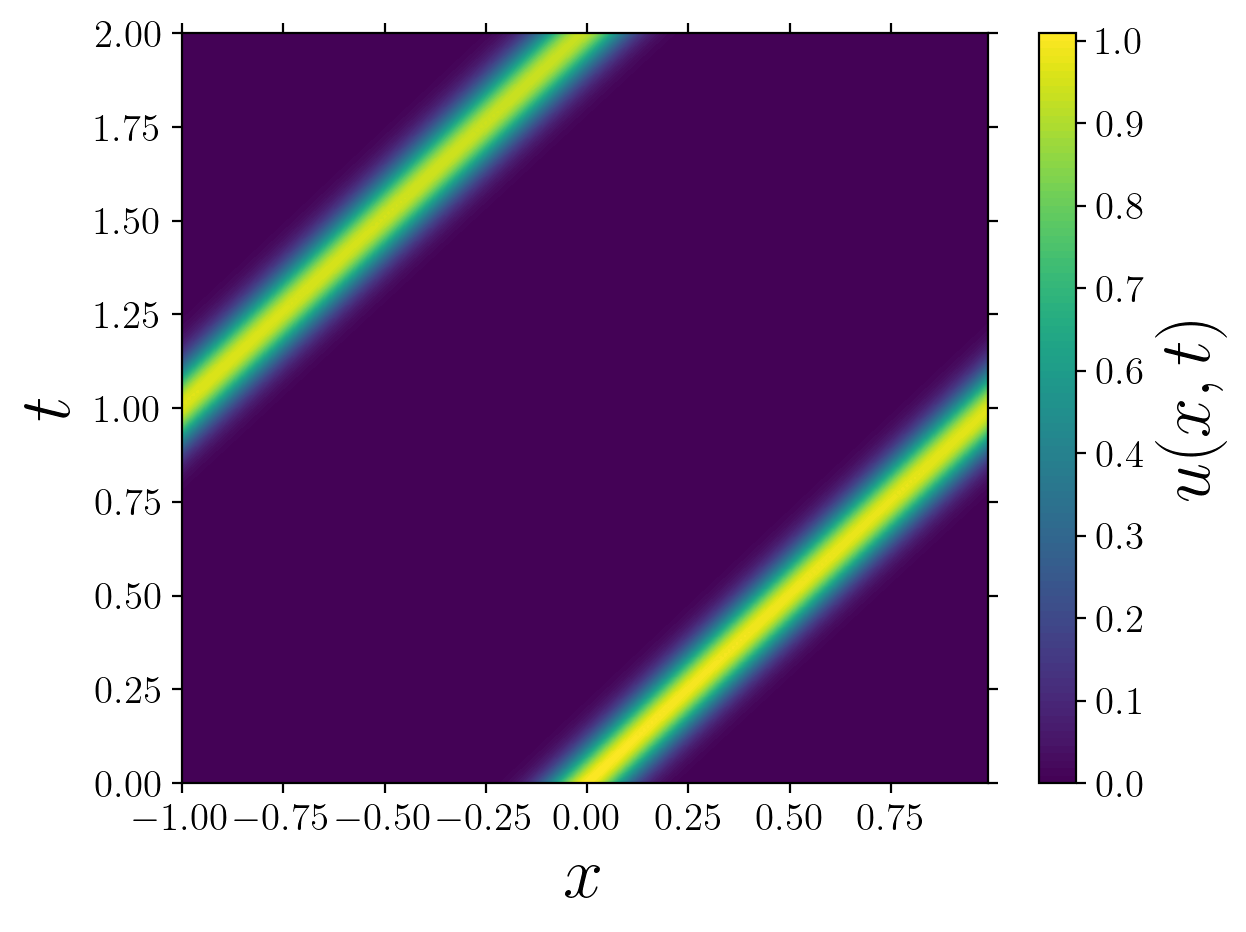

In [9]:
# Make Hovmoeller plot of solution
fig = plt.figure()

times = np.linspace(0., t_max, num=n_t, endpoint=True)

CF = plt.contourf(x, times, u, levels=100)

# axis labels
plt.xlabel(r"$x$", fontsize=26, color = textcolor)
plt.ylabel(r"$t$", fontsize=26, color=textcolor)

plt.tick_params(axis='x', which='both', top='off', color = textcolor)
plt.xticks(fontsize=14, rotation=0, color = textcolor)
plt.tick_params(axis='y', which='both', right='off', color = textcolor)
plt.yticks(fontsize=14, rotation=0, color = textcolor)

# make colorbar
cbar = plt.colorbar(CF,  format='%.1f')
cbar.ax.tick_params(labelsize=14, color=textcolor) 
# plt.clim(0,1)
cbar.ax.set_ylabel(r'$u(x,t)$', fontsize=26, color=textcolor)

# the final piece of the colorbar defn is to change the colorbar ticks to an acceptable color.
# This is not so easy, and relies on the thread at
# https://stackoverflow.com/questions/9662995/matplotlib-change-title-and-colorbar-text-and-tick-colors
cbytick_obj = plt.getp(cbar.ax.axes, 'yticklabels')                
plt.setp(cbytick_obj, color=textcolor)

plt.tight_layout()

fig.set_size_inches(6.33, 4.75)  
        
plt.show()

In [10]:
# Check the L-infty error of the numerical solution at final time
X, T = np.meshgrid(x, times)
Z = (X - c * T + 0.5*length) % length - 0.5*length
u_true = gaussian( Z , a = 100.)

error = np.amax(np.abs(u[-1,:] - u_true[-1,:]))
print("Estimated L^infty error at terminal time = %.3f " % error)

Estimated L^infty error at terminal time = 0.136 
